# Real-time $R_t$ computation on Italian COVID-19 data, by Stefano Terna$^1$

$^1$ PhD, [tomorrowdata.io](https://tomorrowdata.io)

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from numbers import Number

# credits and installation https://github.com/njchiang/tikhonov.git
from tikhonov.TikhonovRegression import Tikhonov

from sklearn.linear_model import LinearRegression
from scipy import stats

In [105]:
def plot_series(title, df, yfields, xfield='data', ylim=None, xlim=None, labelrotation=0):
    fig, ax1 = plt.subplots(figsize=(30,15))
    ax1.set_title(title, fontsize=30)
    ax1.set_xlabel('time (days)', fontsize=30)
    ax1.tick_params(axis='both', labelsize=30)
    ax1.tick_params(axis='x', labelrotation=labelrotation)
    if ylim:
        ax1.set_ylim(*ylim)
    if xlim:
        ax1.set_xlim(*xlim)

    for f in yfields:
        ax1.plot(
            df[xfield], 
            df[f], 
            label=f, 
            linestyle=':', marker='o'
        )

    _ = ax1.legend(fontsize=27, loc='upper left')    

# Two data sources

We have two official data sources:

- ISS data (Istituto Superiore della Sanita')
- pcm-dpc data (Protezione Civile)

See https://www.epicentro.iss.it/coronavirus/sars-cov-2-sorveglianza , at "Perché le informazioni fornite dall’ISS possono differire (essere in ritardo) rispetto a quelle della Protezione civile"


## ISS data (Istituto Superiore della Sanita')

These data are available via the Ministero della Sanita' web site, not in their raw format, but only via descriptive reports.

To obtain the data  one needs to navigate (or scrape) the intricated and non standardized structure of the weekly reports from ministero della Sanita'

What follows is the result of the scraping, aimed to obtain the $Rt$ values computed by ISS.

In the "url" column the url to the official report is reported.

To update the ISS dataset, check manuallty [here](http://www.salute.gov.it/portale/nuovocoronavirus/archivioNotizieNuovoCoronavirus.jsp?lingua=italiano&tipo=Report+settimanale+Covid-19&btnCerca=cerca) for new weekly updates.

In [3]:
ISS_Rt = pd.read_csv(
    './data/sources/Rt_from_ISS.csv',
    parse_dates=['computation_time_range_start', 'computation_time_range_end']
)

In [4]:
ISS_Rt.head()

,ID,report_time_range_descr,computation_time_range_descr,computation_time_range_start,computation_time_range_end,Rt,Rt_95_min,Rt_95_max,notes,source,source_detail,url
0,5169,2 - 8 novembre,22 ottobre - 4 novembre,2020-10-22,2020-11-04,1.43,1.08,1.81,NaN,attachement,imgs/C_17_notizie_5169_0_file.pdf,http://www.salute.gov.it/portale/nuovocoronavi...
1,5157,26 ottobre - 1 novembre,15 - 28 ottobre,2020-10-15,2020-10-28,1.72,1.45,1.83,NaN,attachement,/portale/news/documenti/Epi_aggiornamenti/alle...,http://www.salute.gov.it/portale/nuovocoronavi...
2,5146,19 - 25 ottobre,08 - 21 ottobre 2020,2020-10-08,2020-10-21,1.70,1.49,1.85,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...
3,5137,12-18 ottobre,01 - 14 ottobre 2020,2020-10-01,2020-10-14,1.50,1.09,1.75,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...
4,5125,5-11 ottobre,24 settembre - 07 ottobre,2020-09-24,2020-10-07,1.17,1.03,1.50,NaN,html,NaN,http://www.salute.gov.it/portale/nuovocoronavi...


In [5]:
ISS_Rt_clean = ISS_Rt.loc[:,[
    'computation_time_range_start','computation_time_range_end','Rt','Rt_95_min','Rt_95_max'
]].dropna()

In [6]:
ISS_Rt_clean['Rt_95_err_max'] = ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt
ISS_Rt_clean['Rt_95_err_min'] = np.abs(ISS_Rt_clean.Rt_95_max - ISS_Rt_clean.Rt)

In [7]:
ISS_Rt_clean['Rt_reference_date'] = (
    ISS_Rt_clean.computation_time_range_start + 
    (ISS_Rt_clean.computation_time_range_end - ISS_Rt_clean.computation_time_range_start)/2
)

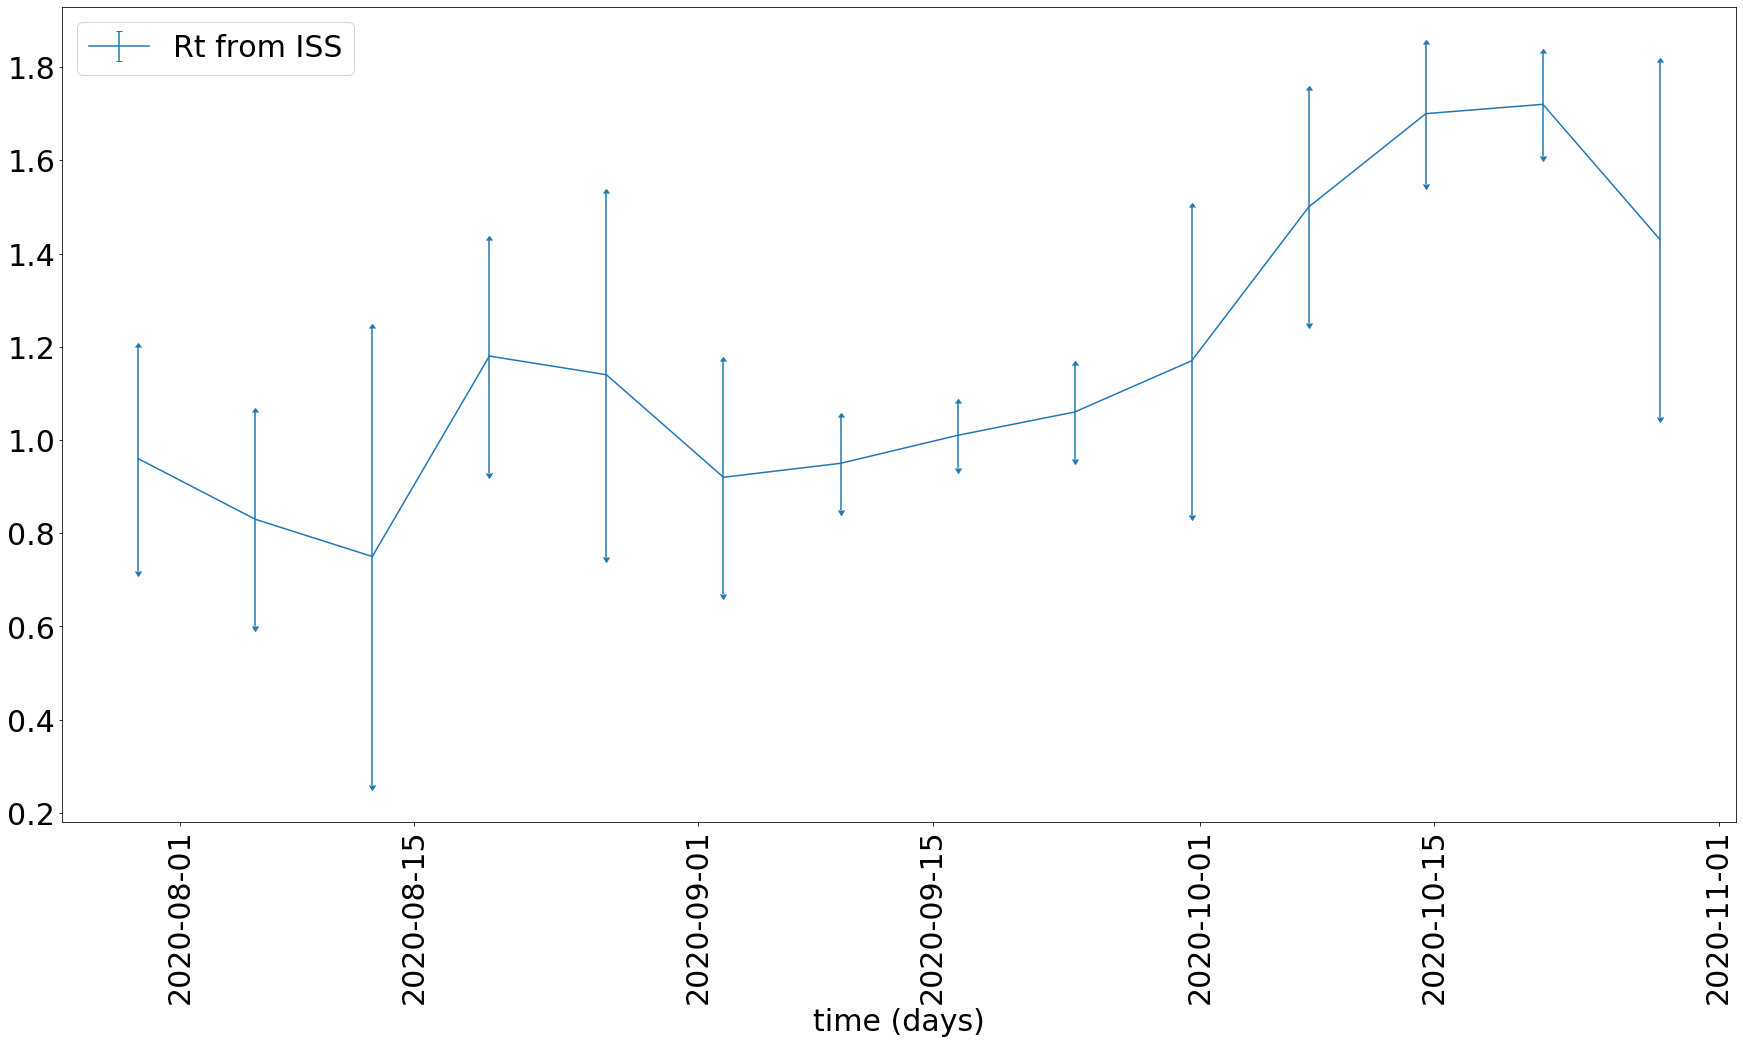

In [8]:
fig, ax1 = plt.subplots(figsize=(30,15))

ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=90)
ax1.set_ylabel('', fontsize=30)
ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS'
)

_ = ax1.legend(fontsize=30)

By the way, this happens to be the only publicly available chart of the ISS computed Rt value, at least to my knowledge.

## Assessing the confidence interval

- why are confidence intervals so different?
- why are they so big?

Confidence bars seems pretty related with the derivative of the signal.
Given that the ISS $R_t$ is the average over 14 days, the hypothesis could be that the confidence intervals are simpli an estimate of the slope of the 14 points averaged. 
The bigger the slope the bigger the confidence interval.

Let's check this hypothesis comparing the amplitude of the confidence intervals with $2(R_{t} - R_{t-7})$, with $2$ being motivated by the fact that the points are 7 days distant, while the averages are taken on 14 days ranges.


In [9]:
ISS_Rt_clean['Rt_95_CI'] = 2*ISS_Rt_clean.Rt_95_err_max
ISS_Rt_clean['Rt_2_abs_D'] = 2*(np.abs(ISS_Rt_clean.Rt - ISS_Rt_clean.Rt.shift(1)))

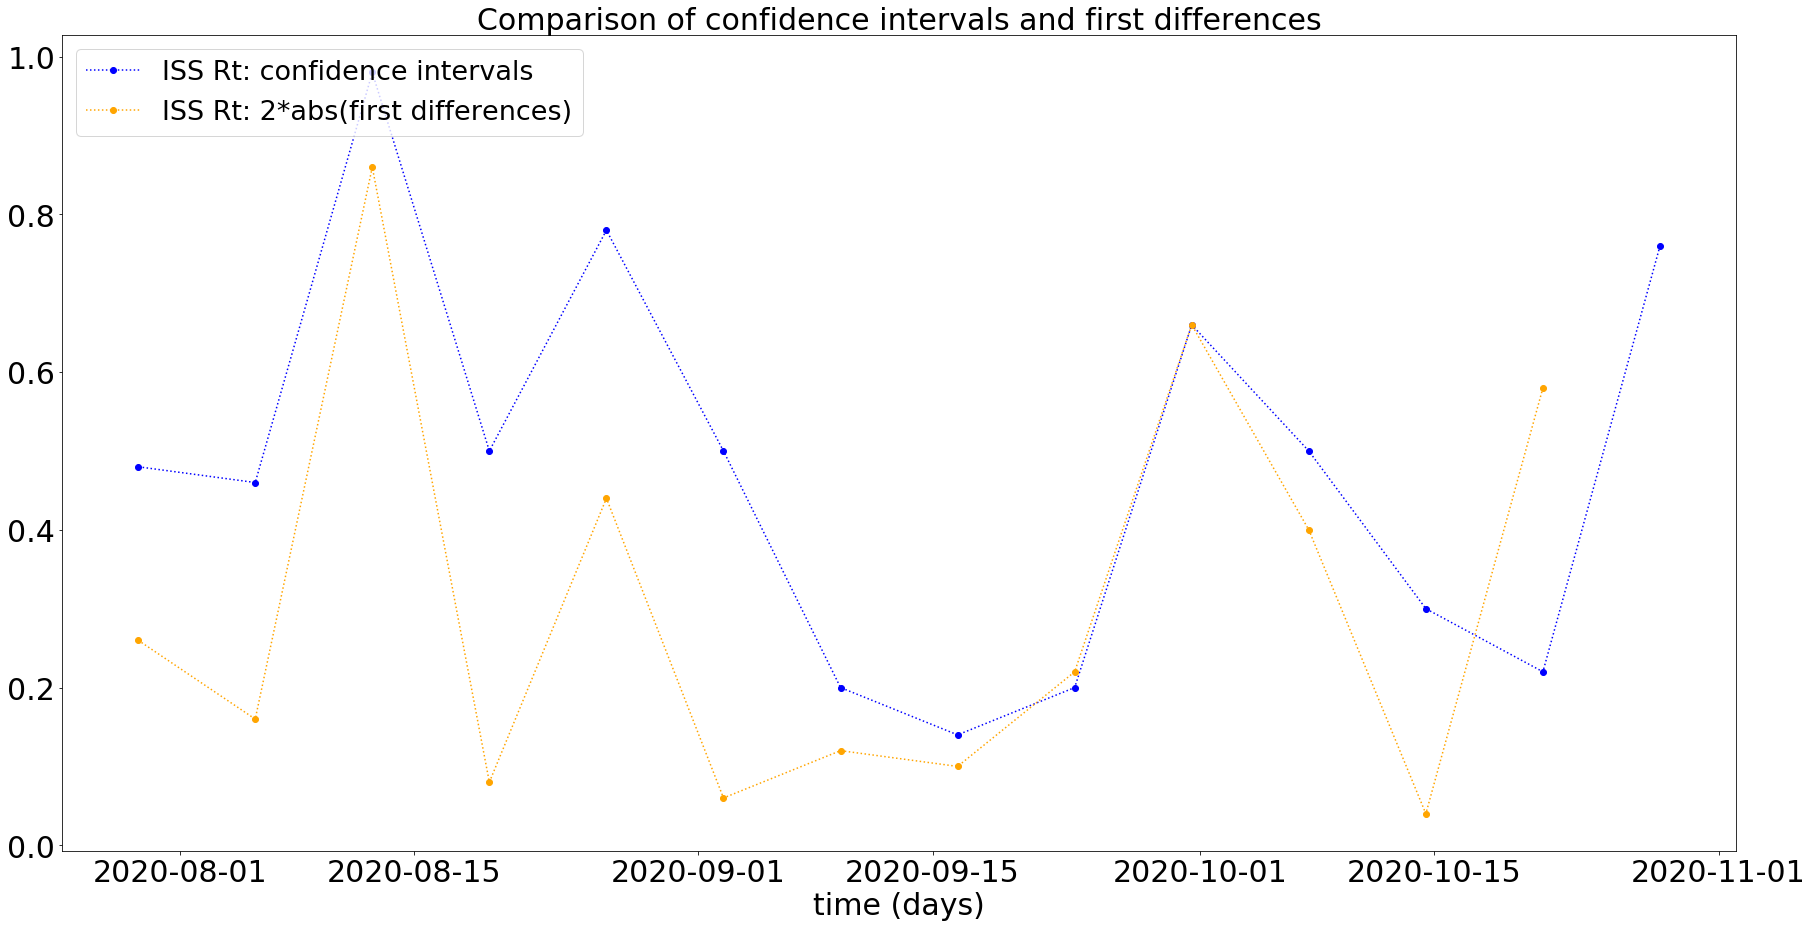

In [10]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Comparison of confidence intervals and first differences', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)

ax1.plot(
    ISS_Rt_clean.Rt_reference_date,
    ISS_Rt_clean.Rt_95_CI, 
    label='ISS Rt: confidence intervals', 
    linestyle=':', marker='o', color = 'blue'
)

ax1.plot(
    ISS_Rt_clean.Rt_reference_date,
    ISS_Rt_clean.Rt_2_abs_D,
    label='ISS Rt: 2*abs(first differences)', 
    linestyle=':', marker='o', color = 'orange'
)

_ = ax1.legend(fontsize=27, loc='upper left')    

# pcm-dpc data (Protezione Civile)

In [11]:
def parse_date_pcm(date):
    return datetime.strptime(date[:10] + ' 23:59:00', '%Y-%m-%d %H:%M:%S')

In [12]:
italy_raw_data = pd.read_csv(
    'https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv',
    parse_dates=['data'],
    date_parser=parse_date_pcm
)

In [13]:
# https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series

# https://arxiv.org/pdf/2004.04529.pdf

# https://github.com/Keystone-Strategy/covid19-intervention-data/

# https://coviz.apps.allenai.org/

In [14]:
italy_raw_data.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati,note
0,2020-02-24 23:59:00,ITA,101,26,127,94,221,0,221,1,7,NaN,NaN,229,4324,NaN,NaN
1,2020-02-25 23:59:00,ITA,114,35,150,162,311,90,93,1,10,NaN,NaN,322,8623,NaN,NaN
2,2020-02-26 23:59:00,ITA,128,36,164,221,385,74,78,3,12,NaN,NaN,400,9587,NaN,NaN
3,2020-02-27 23:59:00,ITA,248,56,304,284,588,203,250,45,17,NaN,NaN,650,12014,NaN,NaN
4,2020-02-28 23:59:00,ITA,345,64,409,412,821,233,238,46,21,NaN,NaN,888,15695,NaN,NaN


In [15]:
italy_raw_data.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note'],
      dtype='object')

In [16]:
TIMESTEPS = len(italy_raw_data.nuovi_positivi)

## Check data consistency

In [17]:
italy_raw_data.describe()

,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,casi_da_sospetto_diagnostico,casi_da_screening,totale_casi,tamponi,casi_testati
count,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,268.000000,146.000000,146.000000,2.680000e+02,2.680000e+02,2.130000e+02
mean,9102.365672,994.026119,10096.395522,76115.902985,86212.294776,2737.272388,4620.212687,161011.361940,29359.130597,291815.993151,87590.520548,2.765829e+05,6.392495e+06,4.817011e+06
std,9832.560349,1213.917959,11013.231129,132120.571780,138807.981847,6874.132406,8811.484745,98354.760596,11806.276513,131386.192404,106083.493925,2.161981e+05,5.085641e+06,2.731634e+06
min,101.000000,26.000000,127.000000,94.000000,221.000000,-6939.000000,78.000000,1.000000,7.000000,221994.000000,15801.000000,2.290000e+02,4.324000e+03,9.353100e+05
25%,1112.500000,93.750000,1211.500000,13809.500000,15213.500000,-311.250000,332.000000,77673.000000,28168.750000,223061.250000,24849.000000,2.069368e+05,2.034873e+06,2.746545e+06
50%,4108.500000,330.000000,4420.000000,34793.500000,41390.000000,464.500000,1366.000000,192528.000000,34884.000000,232476.000000,44509.500000,2.418875e+05,5.682064e+06,4.131535e+06
75%,15817.750000,1596.250000,17635.500000,69051.500000,90029.500000,2016.000000,3618.750000,212621.750000,35598.500000,272347.500000,86066.750000,2.851712e+05,9.676446e+06,6.584670e+06
max,33074.000000,4068.000000,36686.000000,697124.000000,733810.000000,33418.000000,40902.000000,457798.000000,46464.000000,770282.000000,467790.000000,1.238072e+06,1.923951e+07,1.162019e+07


In [18]:
(italy_raw_data.totale_positivi 
 + italy_raw_data.dimessi_guariti 
 + italy_raw_data.deceduti 
 == italy_raw_data.totale_casi).all()

False

In [19]:
italy_raw_data.loc[
    italy_raw_data.totale_positivi 
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'totale_positivi', 'dimessi_guariti', 'deceduti', 'totale_casi']
]

,data,totale_positivi,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,443235,307378,39747,790377


In [20]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    != italy_raw_data.totale_ospedalizzati,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'totale_ospedalizzati']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati
1,2020-02-25 23:59:00,114,35,150


In [21]:
italy_raw_data.loc[
    italy_raw_data.totale_ospedalizzati 
    + italy_raw_data.isolamento_domiciliare 
    != italy_raw_data.totale_positivi,
    ['data', 'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi']    
]

,data,totale_ospedalizzati,isolamento_domiciliare,totale_positivi
1,2020-02-25 23:59:00,150,162,311


In [22]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    != italy_raw_data.totale_positivi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'totale_positivi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,totale_positivi


In [23]:
italy_raw_data.loc[
    italy_raw_data.ricoverati_con_sintomi
    + italy_raw_data.terapia_intensiva
    + italy_raw_data.isolamento_domiciliare
    + italy_raw_data.dimessi_guariti 
    + italy_raw_data.deceduti 
    != italy_raw_data.totale_casi,
    ['data', 'ricoverati_con_sintomi', 'terapia_intensiva', 'isolamento_domiciliare', 
     'dimessi_guariti', 'deceduti', 'totale_casi']    
]

,data,ricoverati_con_sintomi,terapia_intensiva,isolamento_domiciliare,dimessi_guariti,deceduti,totale_casi
254,2020-11-04 23:59:00,22116,2292,418827,307378,39747,790377


# Fix NaN data

`casi_da_sospetto_diagnostico` and `casi_da_screening` have been measured only after a certain date

In [24]:
FIRST_CASI_SOSP_DIAGNOSTICO = italy_raw_data.casi_da_sospetto_diagnostico.first_valid_index()
italy_raw_data.loc[FIRST_CASI_SOSP_DIAGNOSTICO,['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [25]:
italy_raw_data.loc[italy_raw_data.casi_da_screening.first_valid_index(),['data']]

data    2020-06-25 23:59:00
Name: 122, dtype: object

In [26]:
italy_raw_data.casi_da_sospetto_diagnostico.fillna(0, inplace=True)
italy_raw_data.casi_da_screening.fillna(0, inplace=True)

# Compute new cases

In [27]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico'] = \
    (italy_raw_data.casi_da_sospetto_diagnostico -
     italy_raw_data.casi_da_sospetto_diagnostico.shift(1)).fillna(0)

In [28]:
italy_raw_data['nuovi_casi_da_screening'] = \
    (italy_raw_data.casi_da_screening -
     italy_raw_data.casi_da_screening.shift(1)).fillna(0)

# Smoothing data

## Function `smooth_data`

Data are smoothed by fitting a series to represent the derivative of the original signal and then integrating it back to the original signal, which results in a smoothed one.


Given $y$ the signal to be smoothed, we search for the differential signal $\omega$ such that:
$$y = X\cdot \omega$$
where $X$ is the matrix representing the integration operator:
$$X = \begin{bmatrix} 
1 & 0 & 0 & ... & 0 \\
1 & 1 & 0 & ... & 0 \\
1 & 1 & 1 & ... & 0 \\
... & ... & ... & ...  & ... \\
1 & 1 & ... & ... & 1 \\
\end{bmatrix}
$$

$\omega$ is obtained by minimizing the following cost function:
$$F(\omega) = \left\|y - X\cdot\omega\right\|^2 +\alpha^2 \left\|\Gamma\cdot\omega\right\|^2$$

Hence the derivative is fitted using a Ridge regresssion with a generalized Tikhonov regularization factor:
- $y$: the original signal
- $X$: we choose the the integration matrix, to force the fitted signal to be the derivative one
- $\Gamma$: the Tikhonov regularizaztion matrix, choosen as the second derivative operator
- $\alpha$: the regularization factor

The regularization factor penalizes the noise, forcing the derivative to be a smoothed signal.
Once the derivative is fitted, then the original signal is reconstructed by appliyng again the integral matrix to the differentiated signal. The bigger the alpha factor, the smoother the signal.

## Function `smooth_differentiate`
As a by product of this procedure, we can apply the fit to cumulative data to obtain the daily variations, eg to obtain the "nuovi_positivi" from the "totale_casi"

## Function `filter_matrices`
Integral and derivative matrices are just the matrices that applyed to a signal produce the integral or the derivative. They are built via `np.tril`, `np.ones` and `np.eye`.


In [29]:
def filter_matrices(timesteps):
    
    integral_matrix = np.tri(timesteps,timesteps,0)

    derivative_matrix = np.eye(timesteps,timesteps)-(np.tri(timesteps,timesteps,-1)-np.tri(timesteps,timesteps,-2))

    second_derivative_matrix = np.dot(derivative_matrix, derivative_matrix)
    
    return integral_matrix, second_derivative_matrix 


In [30]:
ALPHA = 100.

INTEGRAL_MATRIX, SECOND_DERIVATIVE_MATRIX = filter_matrices(TIMESTEPS)

GAMMA = SECOND_DERIVATIVE_MATRIX

In [31]:
def smooth_data(y, X, L, alpha):    
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.predict(X)

def smooth_differentiate(y, X, L, alpha):
    tic = Tikhonov(alpha=alpha)
    tic.fit(y=y, X=X, L=L)
    print('TIC R2: {}'.format(tic.score(X=X, y=y)))
    
    return tic.coef_

In [32]:
italy_raw_data['tamponi_giornalieri'] = (italy_raw_data.tamponi - italy_raw_data.tamponi.shift(1)).fillna(0)
italy_raw_data['tamponi_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.tamponi, 
                                                                      X=INTEGRAL_MATRIX,
                                                                      L=GAMMA,
                                                                      alpha=ALPHA)

TIC R2: 0.9999905870835791


In [33]:
italy_raw_data['dimessi_guariti_giornalieri'] = (italy_raw_data.dimessi_guariti - italy_raw_data.dimessi_guariti.shift(1)).fillna(0)
italy_raw_data['dimessi_guariti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.dimessi_guariti,
                                                                              X=INTEGRAL_MATRIX,
                                                                              L=GAMMA,
                                                                              alpha=ALPHA)

TIC R2: 0.9999445760481291


In [34]:
italy_raw_data['deceduti_giornalieri'] = (italy_raw_data.deceduti - italy_raw_data.deceduti.shift(1)).fillna(0)
italy_raw_data['deceduti_giornalieri_smoothed'] = smooth_differentiate(italy_raw_data.deceduti,
                                                                       X=INTEGRAL_MATRIX,
                                                                       L=GAMMA,
                                                                       alpha=200.)

TIC R2: 0.9999907176657876


In [35]:
italy_raw_data['nuovi_positivi_smoothed'] = smooth_differentiate(italy_raw_data.totale_casi,
                                                                 X=INTEGRAL_MATRIX,
                                                                 L=GAMMA,
                                                                 alpha=ALPHA)

TIC R2: 0.9999659782444426


In [36]:
italy_raw_data['nuovi_casi_da_sospetto_diagnostico_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_sospetto_diagnostico,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.996449508883836


In [37]:
italy_raw_data['nuovi_casi_da_screening_smoothed'] = \
    smooth_differentiate(italy_raw_data.casi_da_screening,
                         X=INTEGRAL_MATRIX,
                         L=GAMMA,
                         alpha=ALPHA)

TIC R2: 0.9998808348864923


In [38]:
filter_columns = [
    'ricoverati_con_sintomi', 'terapia_intensiva',
    'isolamento_domiciliare', 'totale_positivi',
    'dimessi_guariti', 'deceduti', 'tamponi', 'totale_casi', 'casi_da_screening',
    'casi_da_sospetto_diagnostico'
]

for col in filter_columns:
    italy_raw_data[col+'_smoothed'] = smooth_data(y=italy_raw_data[col],
                                              X=INTEGRAL_MATRIX,
                                              L=GAMMA,
                                              alpha=ALPHA)

TIC R2: 0.999772765254205
TIC R2: 0.9998563633278071
TIC R2: 0.999866013858068
TIC R2: 0.9998801790664659
TIC R2: 0.9999445760481291
TIC R2: 0.9999914113072149
TIC R2: 0.9999905870835791
TIC R2: 0.9999659782444426
TIC R2: 0.9998808348864923
TIC R2: 0.996449508883836


# Residuals

Check the residuals of the raw signals versus the smoothed ones, specifically for the following fields:

- `nuovi_positivi`
- `nuovi_casi_da_accertamento_diagnostico`
- `nuovi_casi_da_screening`

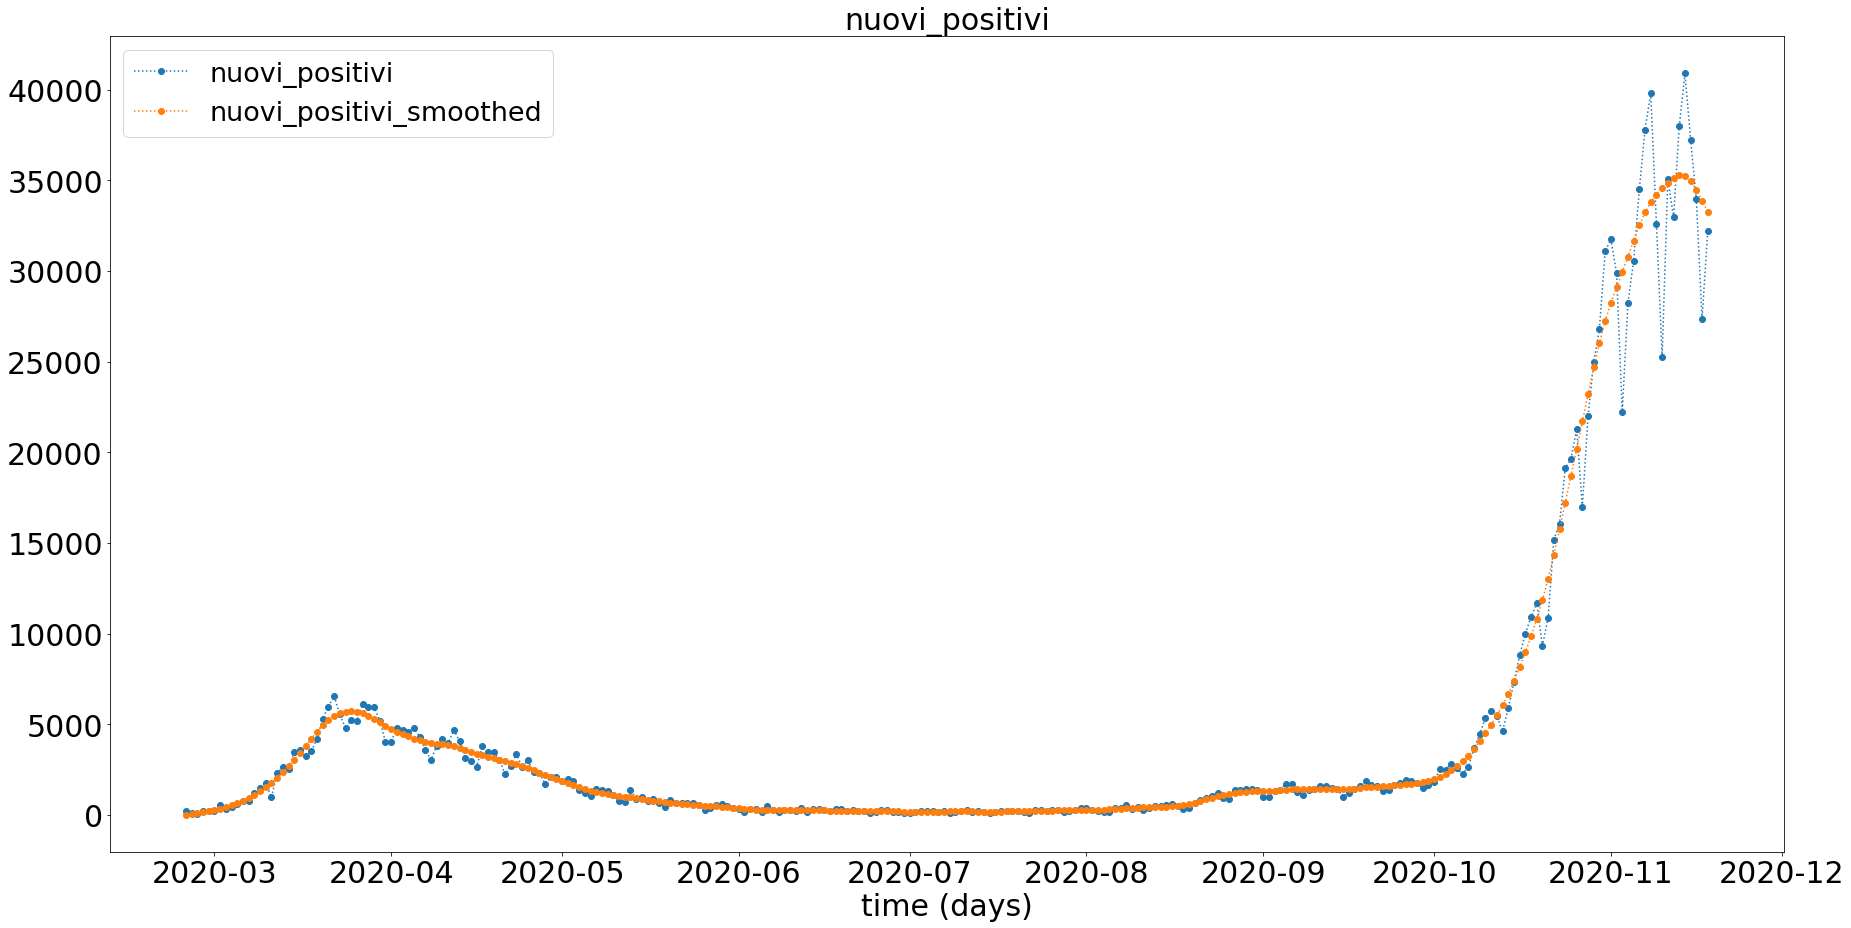

In [39]:
plot_series(
    'nuovi_positivi',    
    italy_raw_data, 
    [
        'nuovi_positivi',
        'nuovi_positivi_smoothed'
    ],
    #ylim=(0.2,3)
)

In [40]:
italy_raw_data['nuovi_positivi_residuals'] = (
    italy_raw_data.nuovi_positivi - italy_raw_data.nuovi_positivi_smoothed
)
italy_raw_data['nuovi_positivi_relative_residuals'] = (
    italy_raw_data.nuovi_positivi_residuals / italy_raw_data.nuovi_positivi_smoothed
)
italy_raw_data.loc[0,'nuovi_positivi_relative_residuals'] = 0

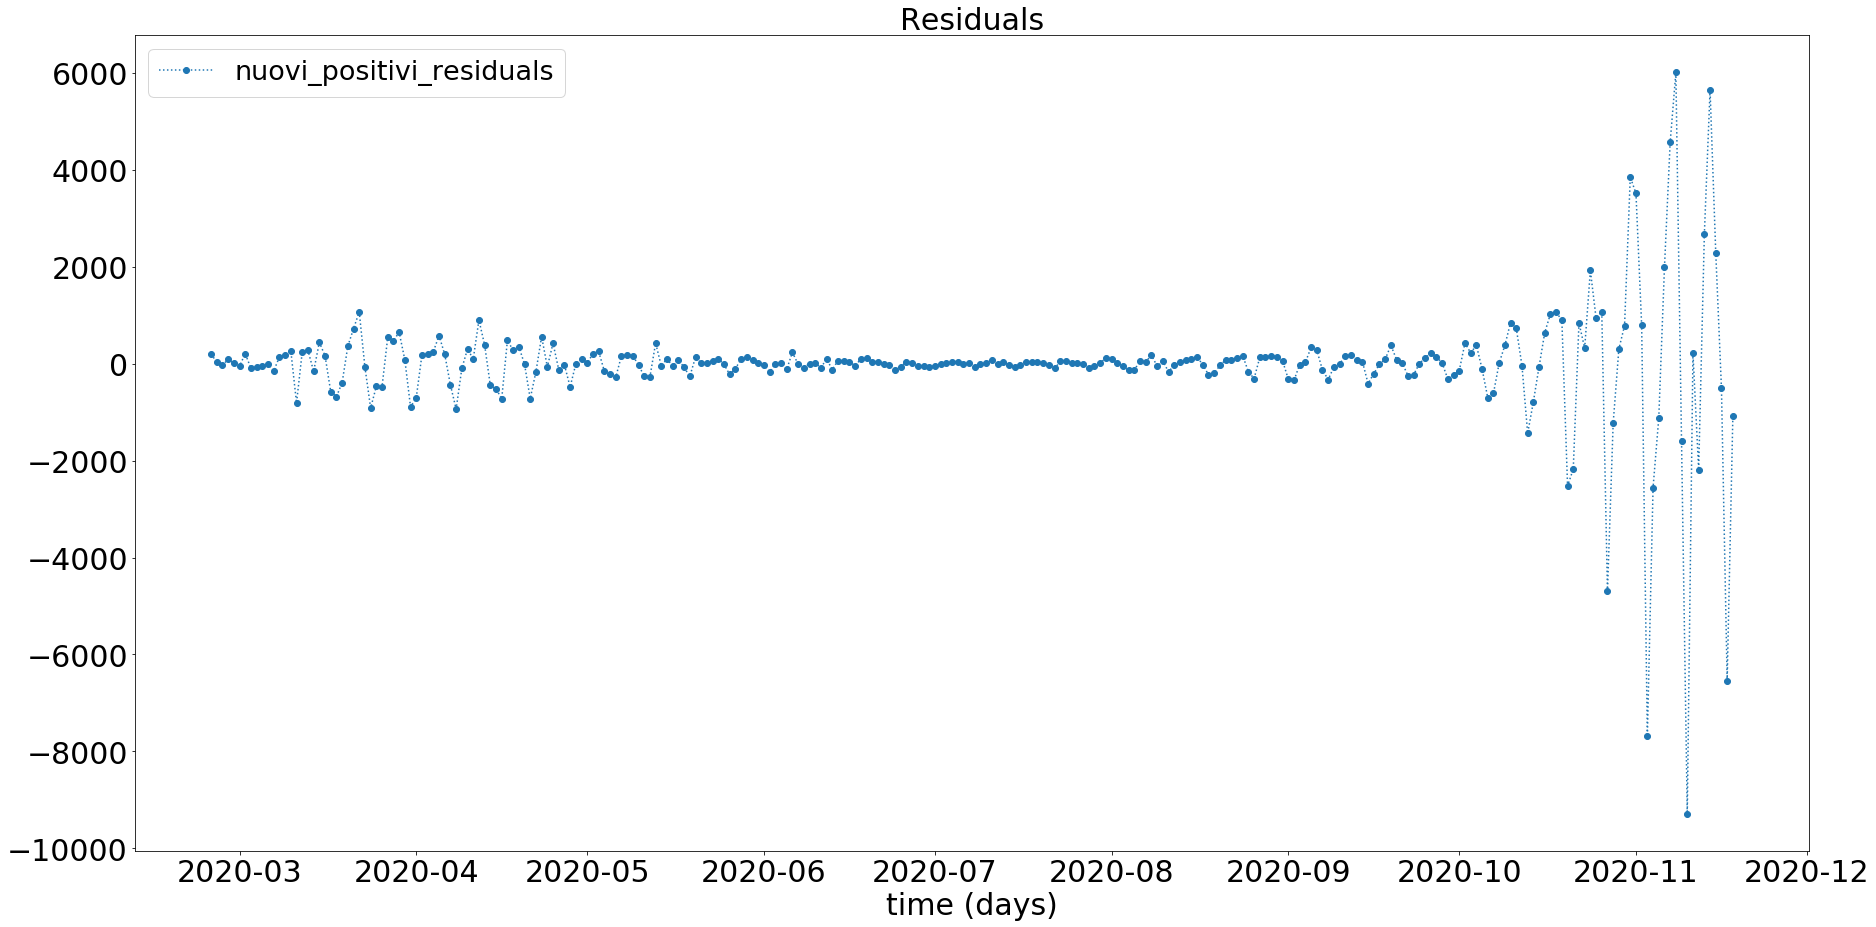

In [41]:
plot_series(
    'Residuals',    
    italy_raw_data, 
    [
        'nuovi_positivi_residuals'
    ],
    #ylim=(0.2,3)
)

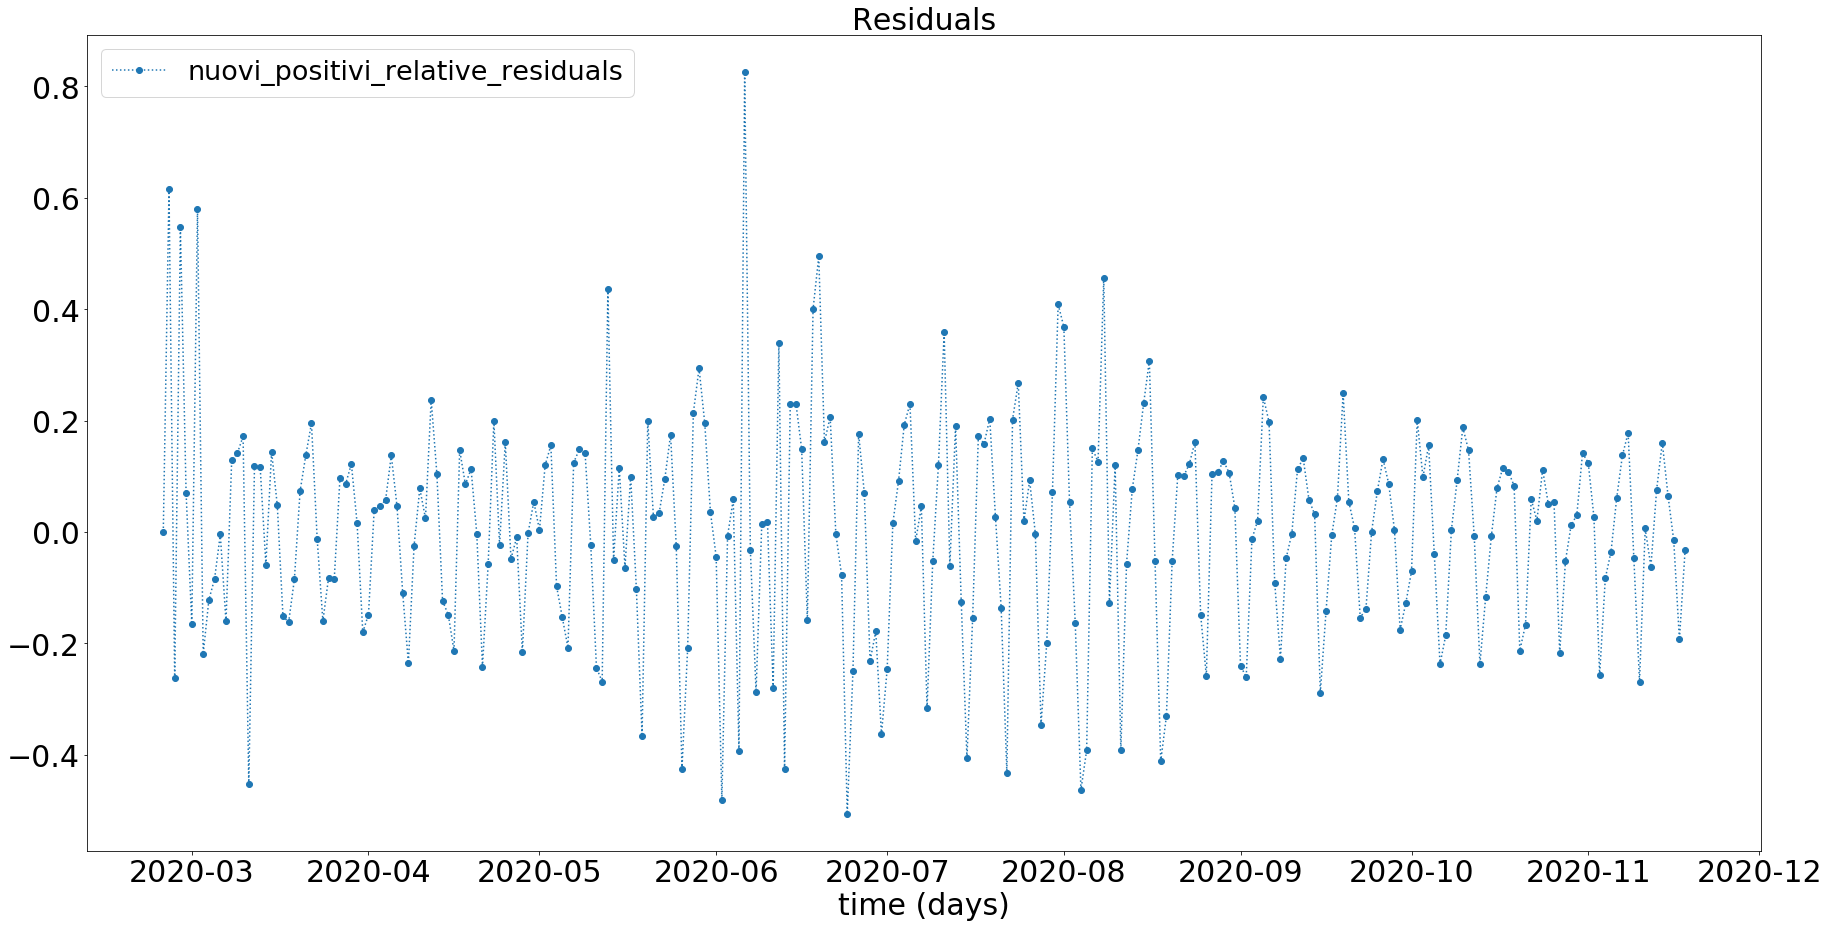

In [42]:
plot_series(
    'Residuals',    
    italy_raw_data, 
    [
        'nuovi_positivi_relative_residuals'
    ],
    #ylim=(0.2,3)
)

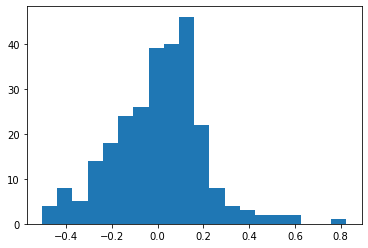

In [43]:
_= plt.hist(italy_raw_data.nuovi_positivi_relative_residuals, bins=20)

In [44]:
relative_residuals_mu, relative_residuals_sigma = stats.norm.fit(italy_raw_data.nuovi_positivi_relative_residuals)

In [45]:
relative_residuals_mu, relative_residuals_sigma

(0.003910259165984909, 0.19879334547377905)

In [46]:
italy_raw_data.nuovi_positivi_relative_residuals.mean()

0.003910259165984909

# Generate multiple runs of the epidemic

In [48]:
OCCURRENCES = 1000

epidemic_runs = []

for i in range(OCCURRENCES):
    relative_residuals = stats.norm.rvs(
        relative_residuals_mu, relative_residuals_sigma, 
        size=TIMESTEPS
    )
    epidemic_runs.append(
        italy_raw_data.nuovi_positivi_smoothed +
        italy_raw_data.nuovi_positivi_smoothed * relative_residuals
    )

# Compute $R_t$

Definitions and parameters are form Ref: https://www.iss.it/primo-piano/-/asset_publisher/o4oGR9qmvUz9/content/faq-sul-calcolo-del-rt

$R_t$ si defined as:

$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

Where:
- $I_t$ is `nuovi_positivi` at day t, or any first difference of a cumulative value
- $w_s=\Gamma(s; \alpha,\beta)$
- $\alpha = 1.87$
- $\beta = 0.28$

In [49]:
def gamma_df(x, alpha, beta):
    return stats.gamma.pdf(x, a=alpha, scale=1/beta)

In [50]:
def gamma_pf(x, alpha, beta):
    return stats.gamma.ppf(x, a=alpha, scale=1/beta)

In [51]:
def Rt(series, alpha, beta):
    steps = len(series)
    x = np.linspace(1,steps-1, steps)
    w = gamma_df(x, alpha, beta)
    
    infectious_charge = [np.nan] + [
        sum(series[t-1::-1]*w[:t]) 
        for t in range(1, steps)        
    ]
    
    return series / infectious_charge

## Compute $R_t$ on every first difference available

Computation is performed for the following fields:
- `nuovi_positivi`: first difference of `nuovi_casi`
- `nuovi_casi_da_sospetto_diagnostico`: first difference of `casi_da_sospetto_diagnostico`
- `nuovi_casi_da_screening`: first difference of `casi_da_screening`

Each computation is performed both on the raw values **and on the smoothed values**.

In [52]:
alpha = 1.87
beta = 0.28

rt_on_fields = [
    'nuovi_positivi',
    'nuovi_casi_da_sospetto_diagnostico',
    'nuovi_casi_da_screening'
]

for c in rt_on_fields + ['{}_smoothed'.format(c) for c in rt_on_fields]:
    italy_raw_data['{}_Rt'.format(c)] = Rt(italy_raw_data[c], alpha=alpha, beta=beta).fillna(0)

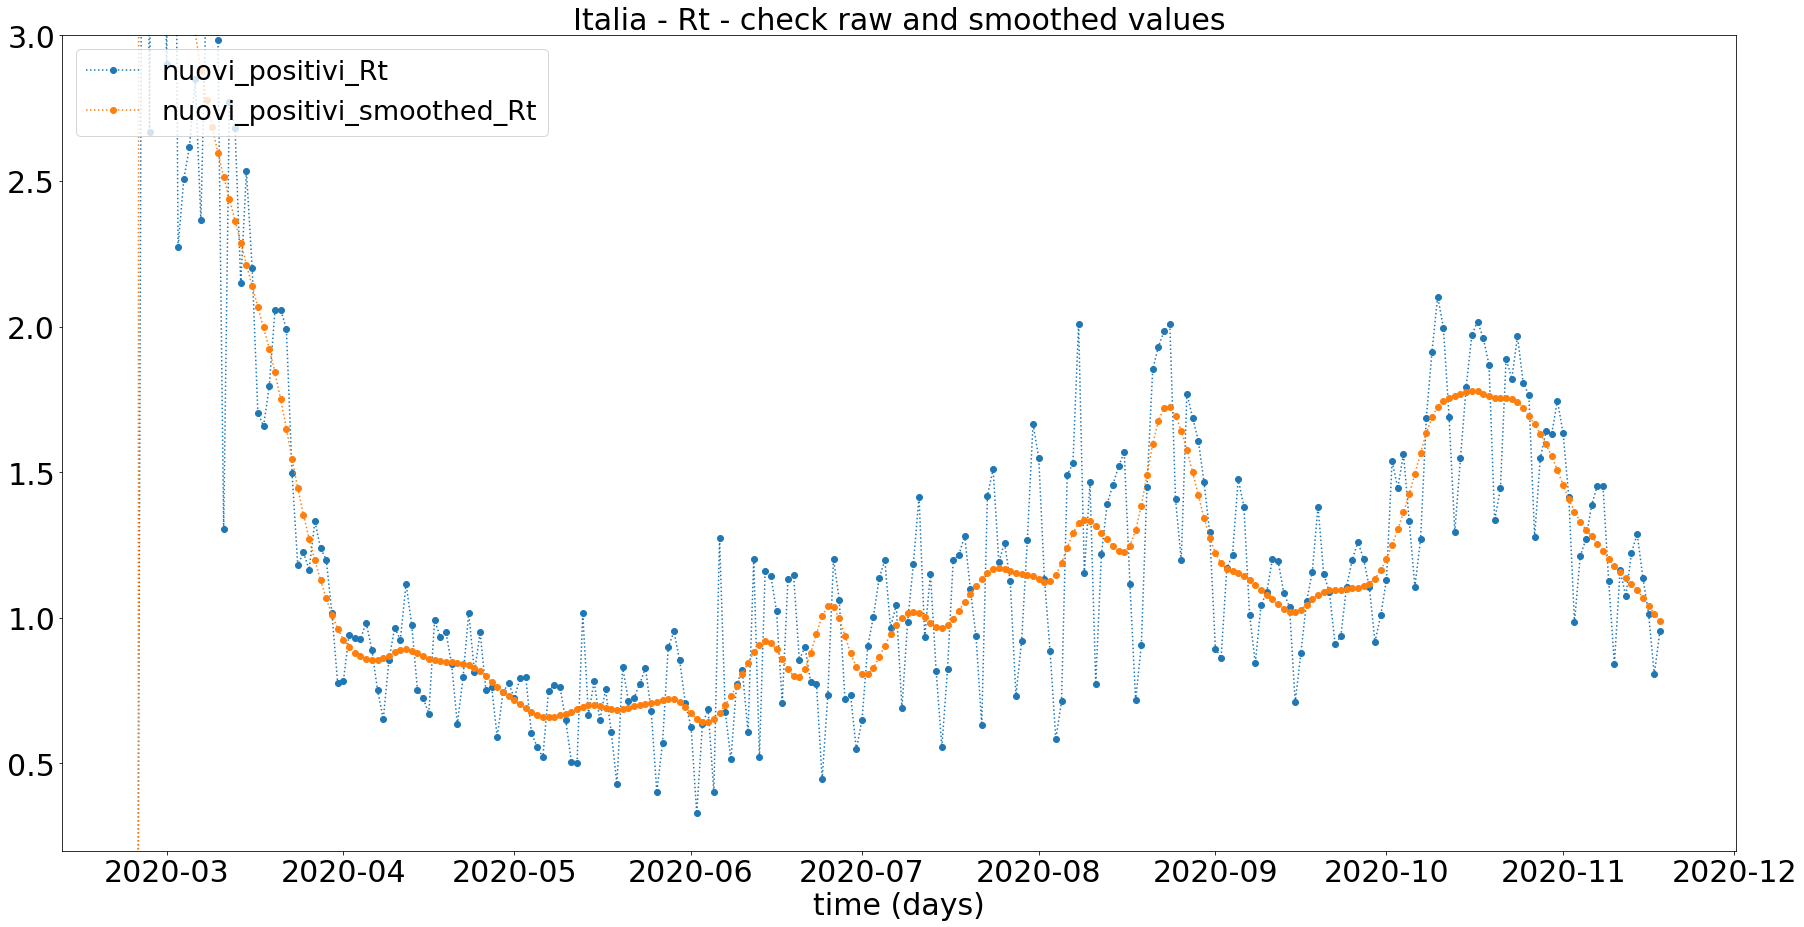

In [53]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.2,3)
)

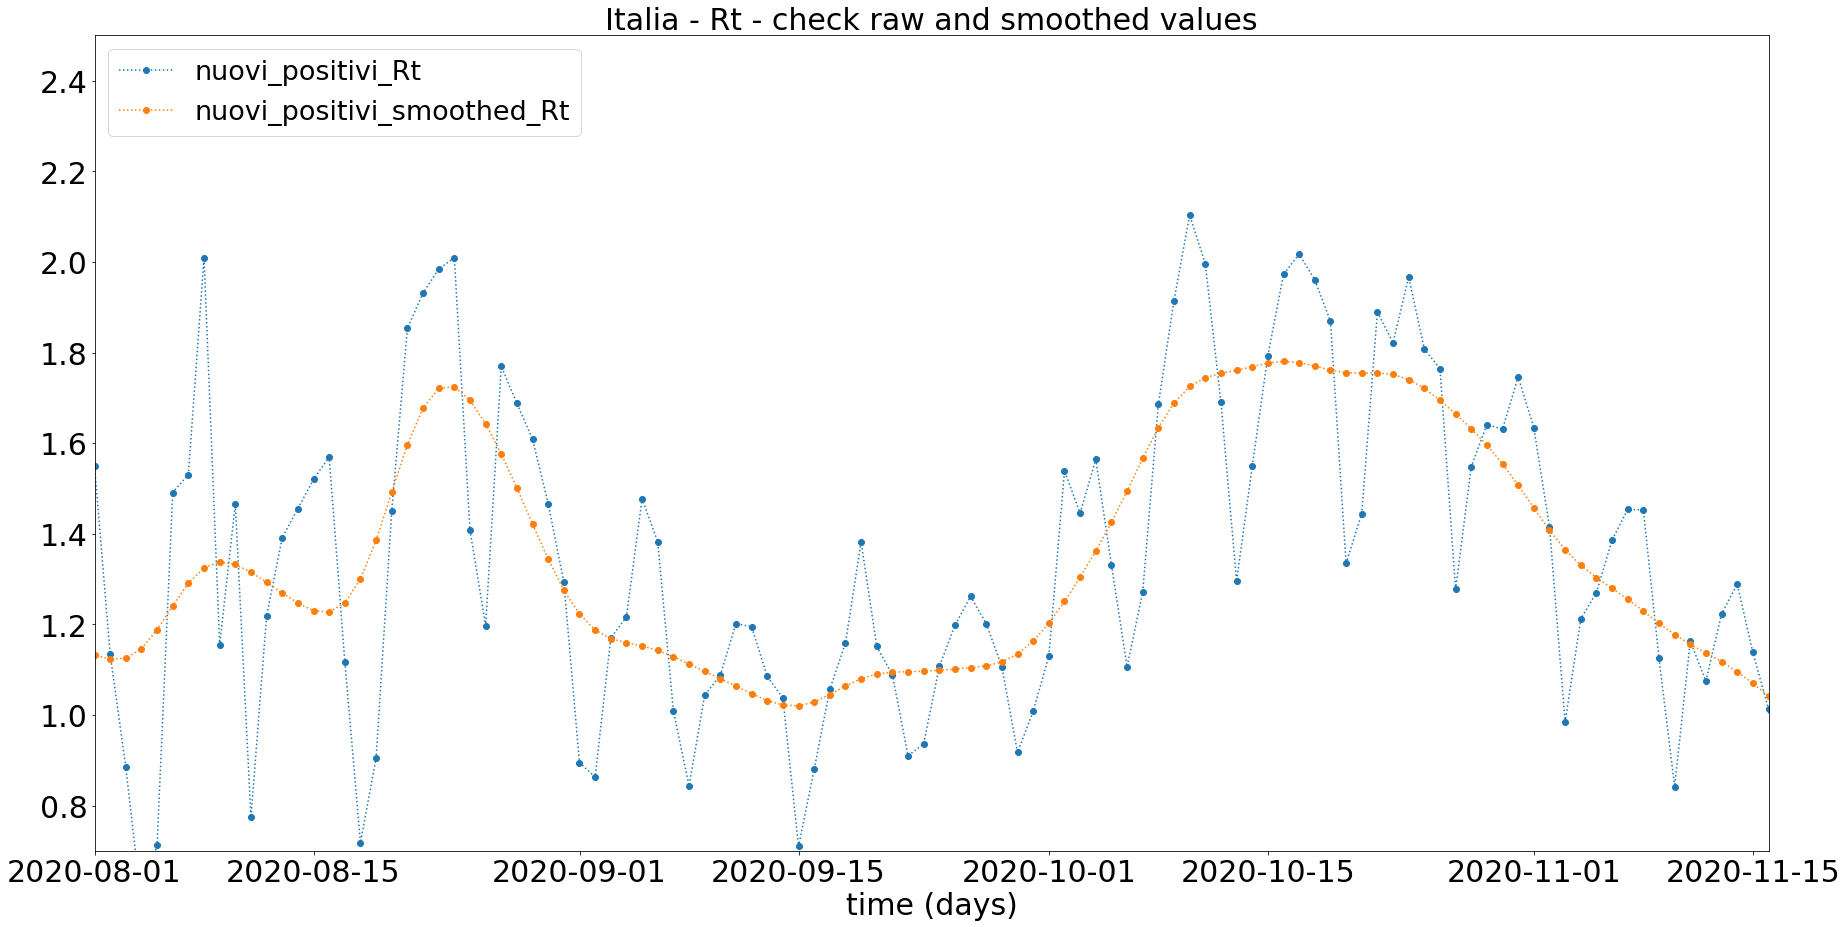

In [54]:
plot_series(
    'Italia - Rt - check raw and smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_positivi_smoothed_Rt'
    ],
    ylim=(0.7,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

## Compare $R_t$ values computed on the 3 first differences

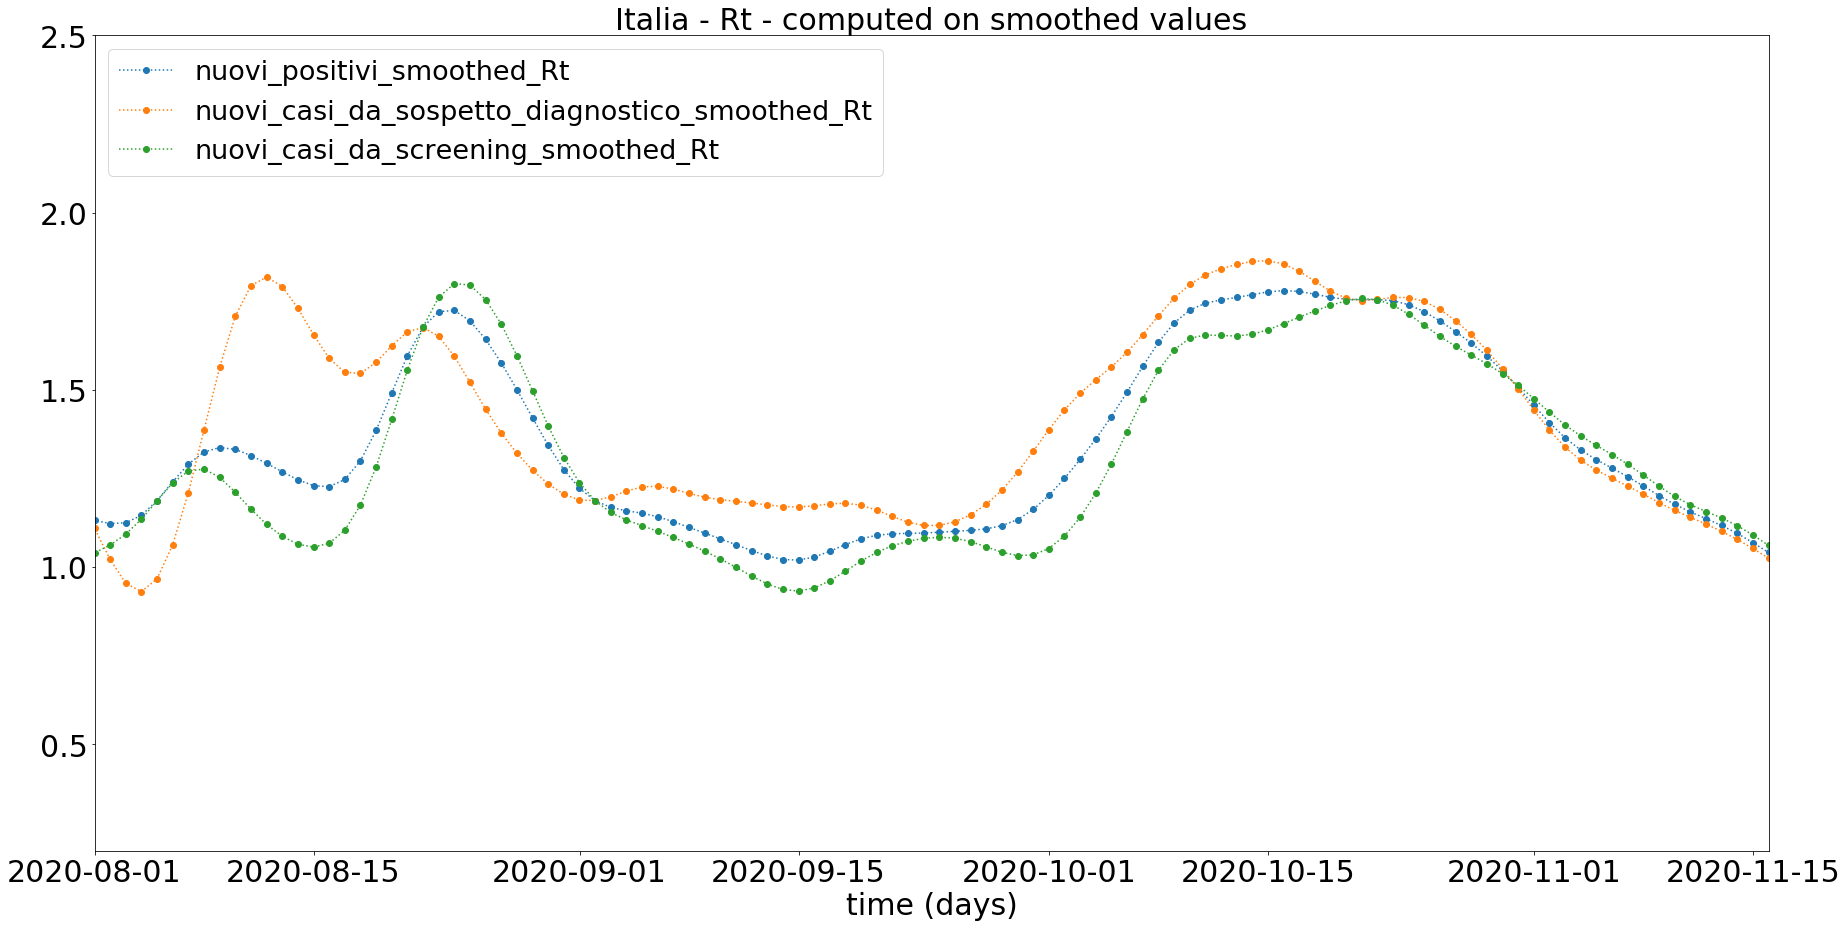

In [55]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

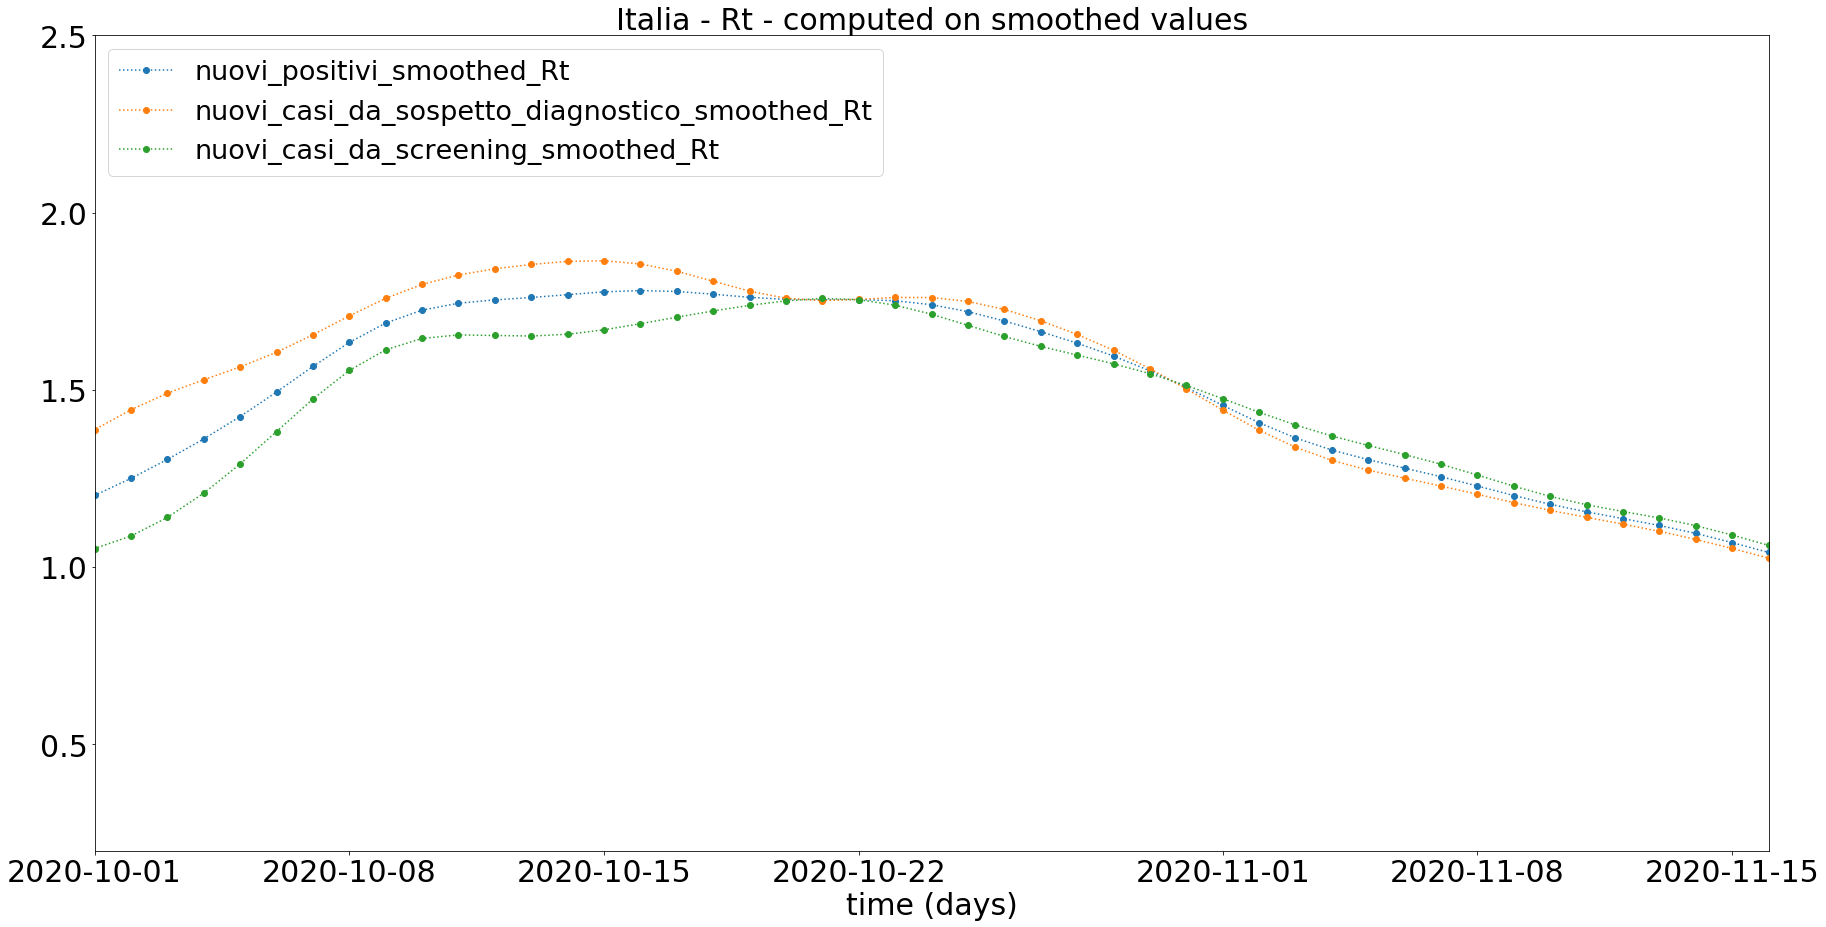

In [56]:
plot_series(
    'Italia - Rt - computed on smoothed values',    
    italy_raw_data, 
    [
        'nuovi_positivi_smoothed_Rt',
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'nuovi_casi_da_screening_smoothed_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,10,1),datetime(2020,11,16))
)

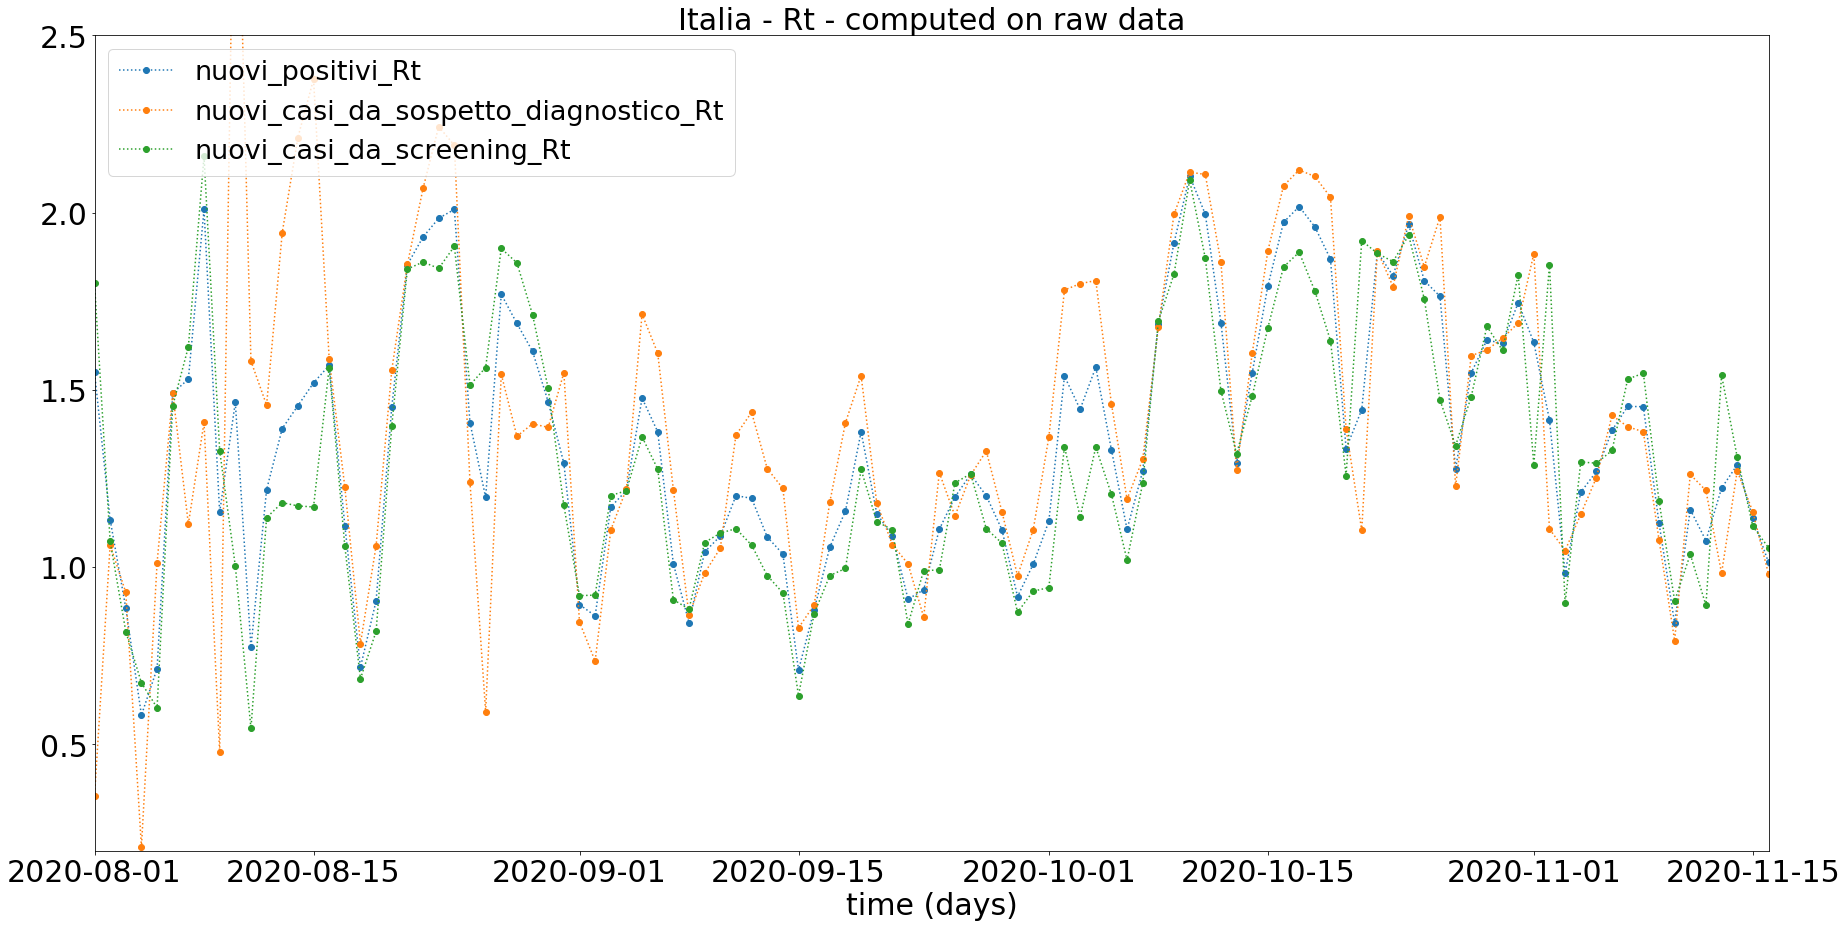

In [57]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_positivi_Rt',
        'nuovi_casi_da_sospetto_diagnostico_Rt',
        'nuovi_casi_da_screening_Rt'
    ],
    ylim=(0.2,2.5),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

# Assess $R_t$ via perturbations

Let's add a perturbation $p_t$ to the original cumulative signal, and compute again the first difference:

$$\large{C_t = \sum_{s=1}^{t} I_t}$$

$$\large{\hat{C}_t = C_t + p_t}$$

$$\large{\hat{I}_t = \hat{C}_t-\hat{C}_{t-1}}$$


## Rate perturbation

The constant rate pertubation is defined as:

$$\large{p_{t+1} = p_t  (1+r_t)} $$

where:
- $r_t$ is the growth rate of the perturbation; it can be a function of time.

In [58]:
def growth(v,rate, zerosteps, steps):
    assert(zerosteps < steps)
    if isinstance(rate, Number):
        ratefunc = lambda s: rate
    elif callable(rate):
        ratefunc = rate
    else:
        raise Exception("rate must be either a number or a function")
    for s in range(steps):
        if s <= zerosteps:
            yield 0.
        else:
            r = ratefunc(s)
            v = v * (1. + r)
            yield v

In [59]:
p0 = 40.
rate=0.1
perturbation = pd.Series(growth(p0,rate, FIRST_CASI_SOSP_DIAGNOSTICO, TIMESTEPS))

cumulative_hat = italy_raw_data.casi_da_sospetto_diagnostico + perturbation

nuovi_casi_hat = smooth_differentiate(
    cumulative_hat,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

nuovi_perturbation = smooth_differentiate(
    perturbation,
    X=INTEGRAL_MATRIX,
    L=GAMMA,
    alpha=ALPHA
)

Rt_nuovi_casi_hat = Rt(nuovi_casi_hat, alpha=alpha, beta=beta)
Rt_perturbation = Rt(nuovi_perturbation, alpha=alpha, beta=beta)

italy_raw_data['perturbation_Rt'] = Rt_perturbation
italy_raw_data.perturbation_Rt.fillna(0, inplace=True)

italy_raw_data['casi_da_sospetto_diagnostico_smoothed_perturbed_Rt'] = Rt_nuovi_casi_hat
italy_raw_data.casi_da_sospetto_diagnostico_smoothed_perturbed_Rt.fillna(0, inplace=True)


TIC R2: 0.9999924855551023
TIC R2: 0.999995401088114


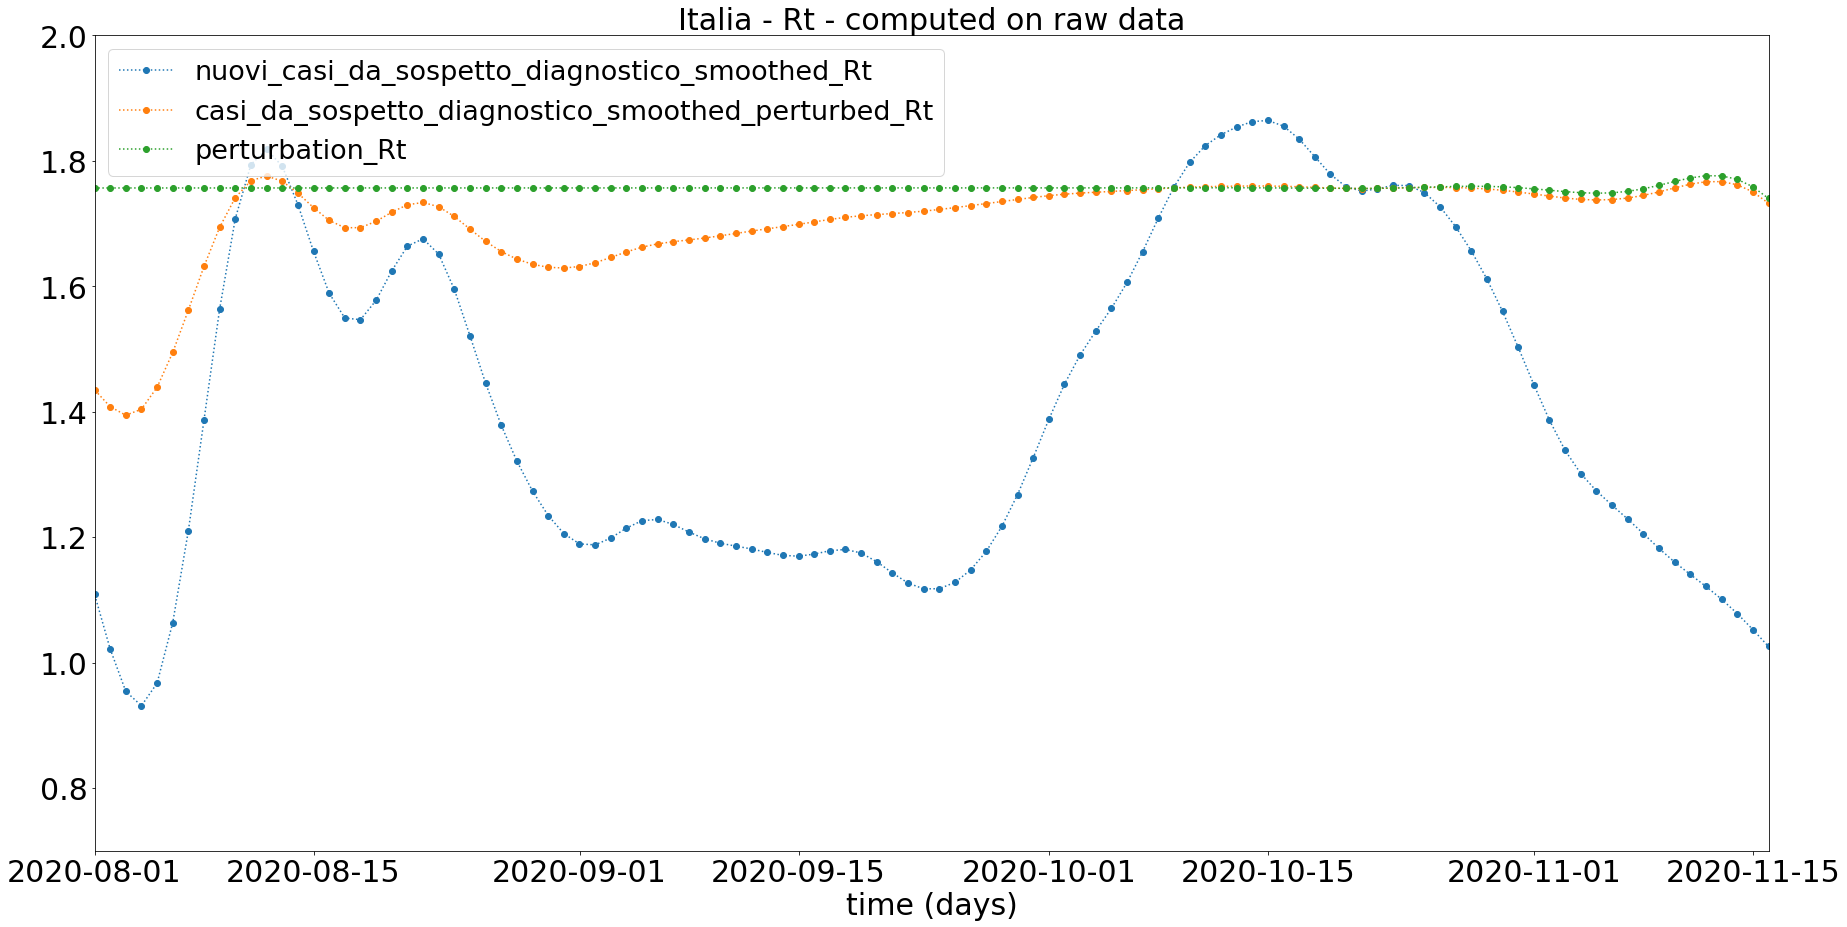

In [60]:
plot_series(
    'Italia - Rt - computed on raw data',    
    italy_raw_data, 
    [
        'nuovi_casi_da_sospetto_diagnostico_smoothed_Rt',
        'casi_da_sospetto_diagnostico_smoothed_perturbed_Rt',
        'perturbation_Rt'
    ],
    ylim=(0.7,2),
    xlim=(datetime(2020,8,1),datetime(2020,11,16))
)

# Comparison of ISS and realtime Rt values

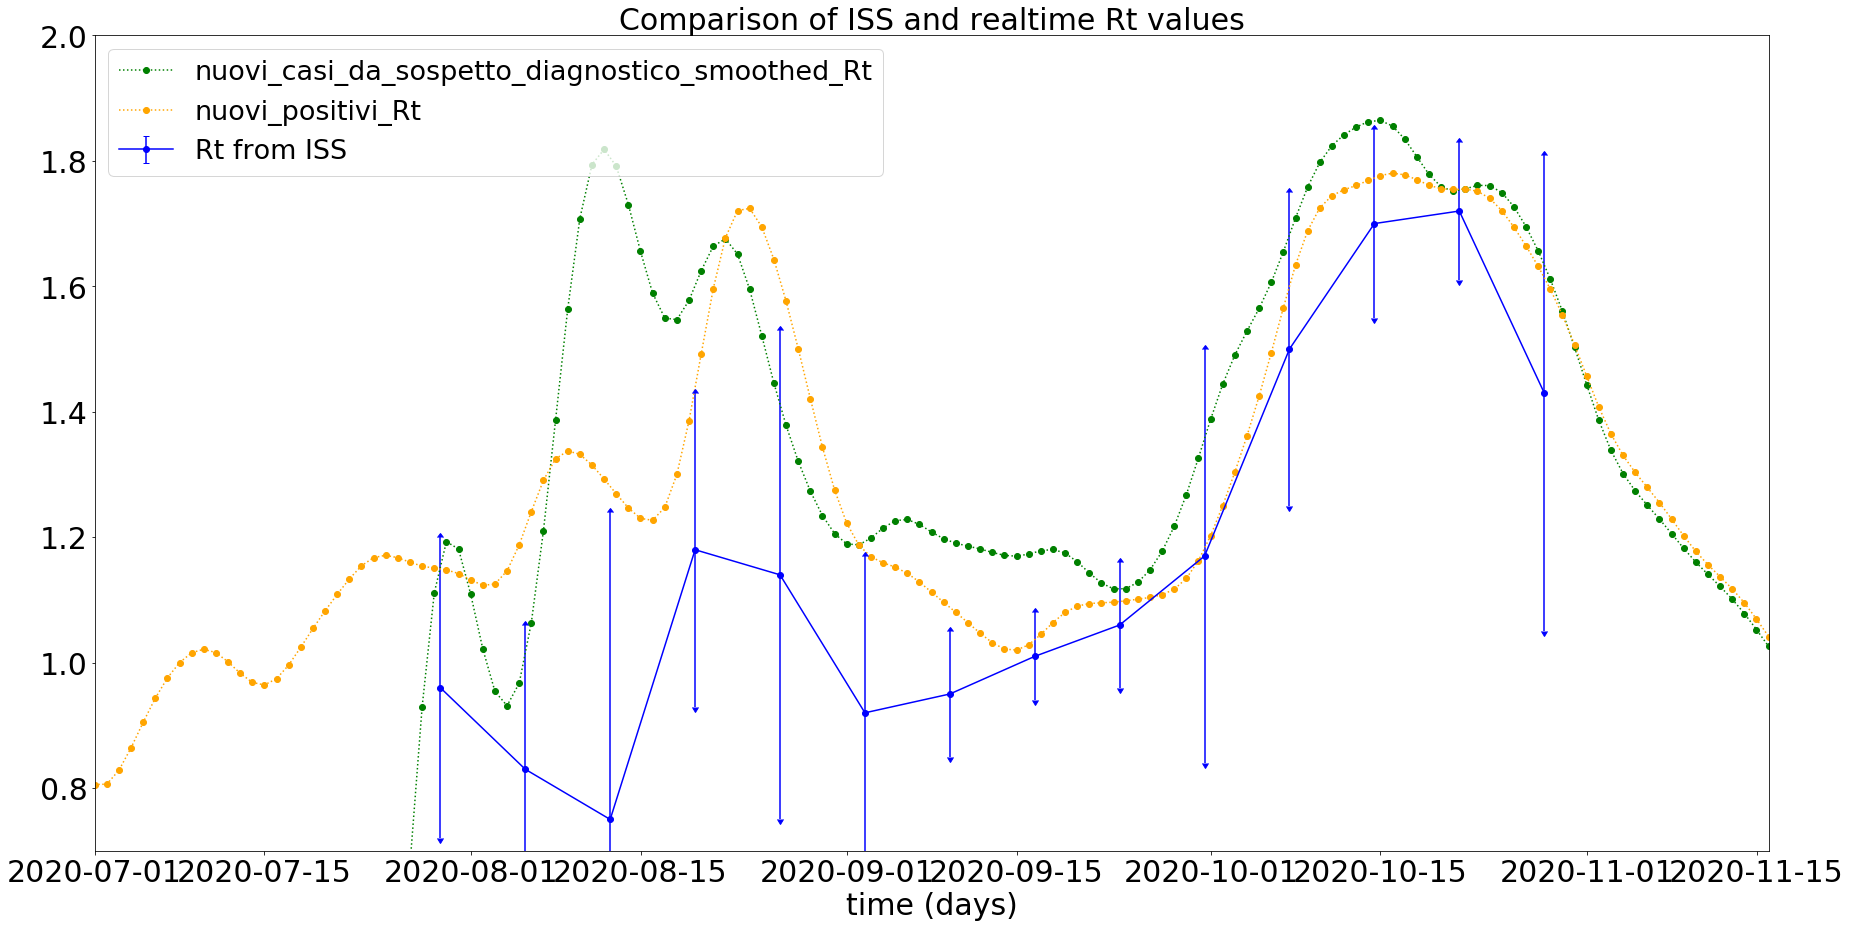

In [61]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Comparison of ISS and realtime Rt values', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)

ax1.set_ylim(0.7,2)
ax1.set_xlim(datetime(2020,7,1),datetime(2020,11,16))

ax1.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_casi_da_sospetto_diagnostico_smoothed_Rt, 
    label='nuovi_casi_da_sospetto_diagnostico_smoothed_Rt', 
    linestyle=':', marker='o', color = 'green'
)

ax1.plot(
    italy_raw_data.data, 
    italy_raw_data.nuovi_positivi_smoothed_Rt, 
    label='nuovi_positivi_Rt', 
    linestyle=':', marker='o', color = 'orange'
)

ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS',
    marker='o', color = 'blue'
)


_ = ax1.legend(fontsize=27, loc='upper left')    

# Compute $R_t$ on multiple epidemic runs to estimate the confidence interval

In [63]:
epidemic_runs_Rt = []

for i in range(OCCURRENCES):
    epidemic_runs_Rt.append(Rt(epidemic_runs[i], alpha=alpha, beta=beta))

In [66]:
epidemic_runs_Rt = np.asarray(epidemic_runs_Rt)

In [67]:
epidemic_runs_Rt.shape

(1000, 268)

In [102]:
confidence_intervals = np.asarray(
    stats.norm.interval(
        0.95, 
        epidemic_runs_Rt.mean(axis=0), 
        epidemic_runs_Rt.std(axis=0)
    )
)
confidence_intervals[0,:] = epidemic_runs_Rt.mean(axis=0)-confidence_intervals[0,:]
confidence_intervals[1,:] = -epidemic_runs_Rt.mean(axis=0)+confidence_intervals[1,:]

In [97]:
italy_raw_data['nuovi_positivi_1000_epidemic_runs_Rt'] = epidemic_runs_Rt.mean(axis=0)

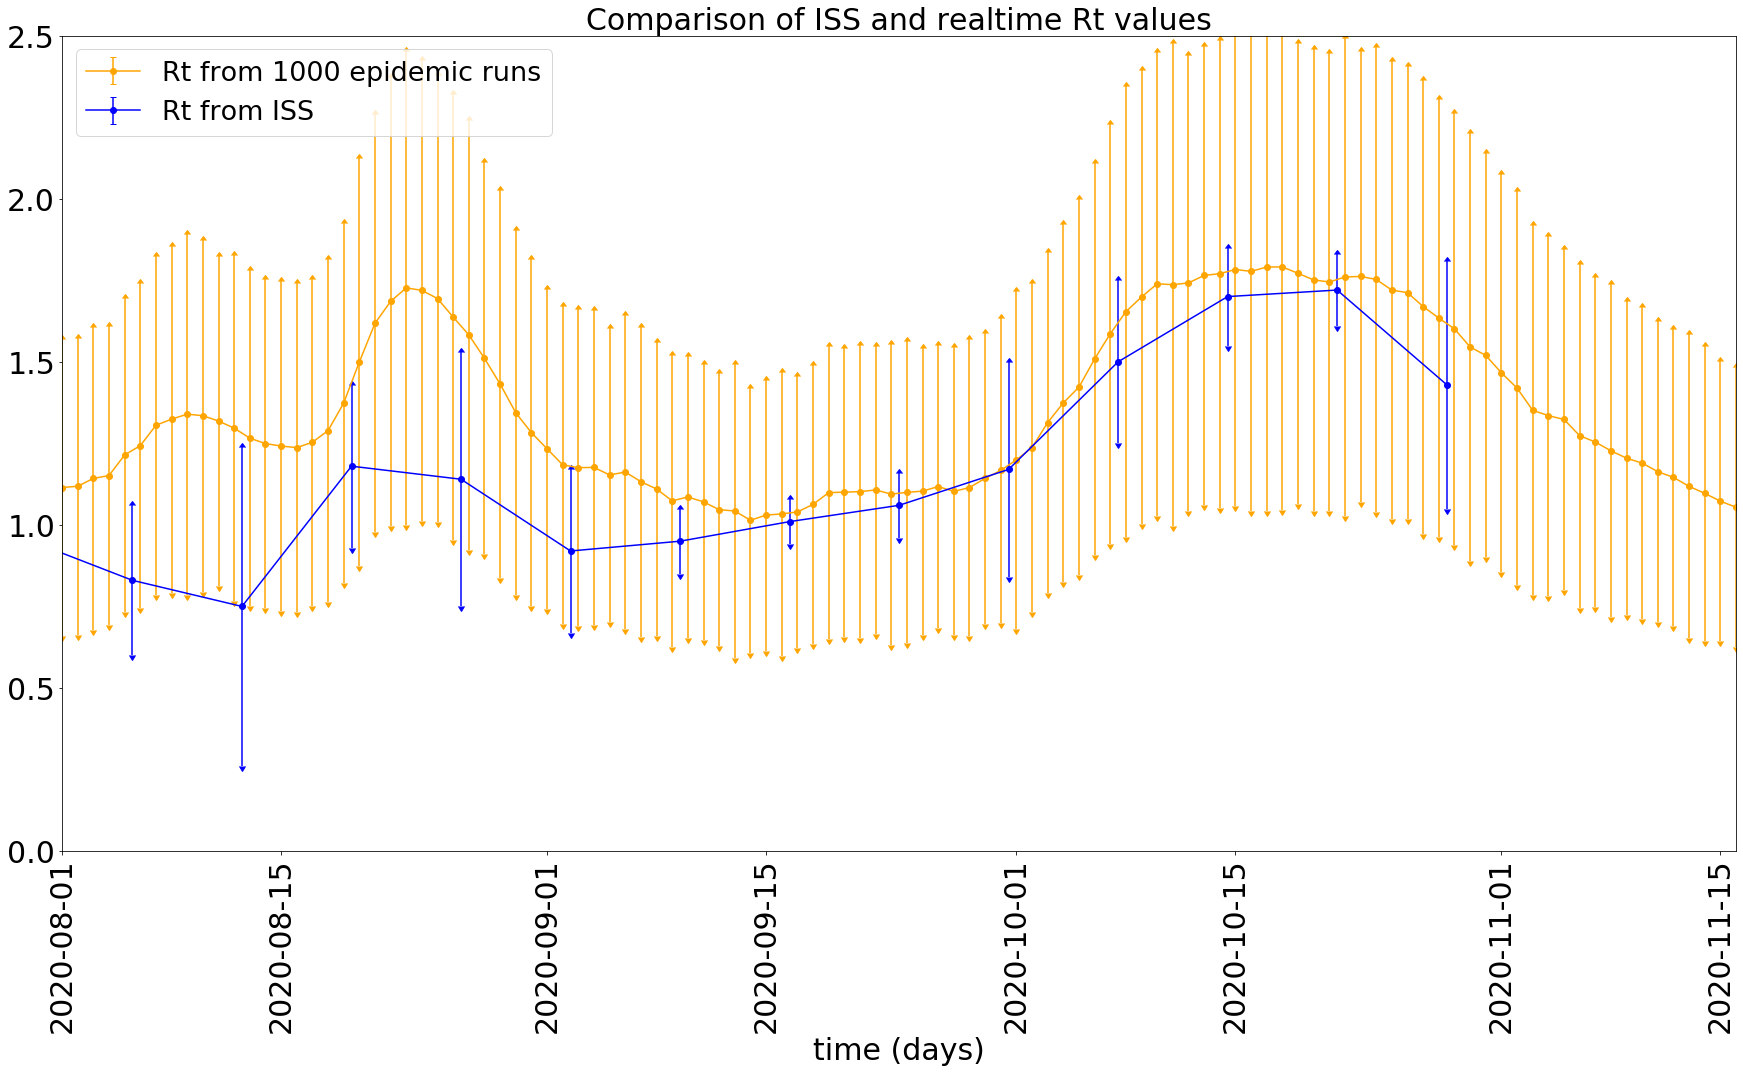

In [110]:
fig, ax1 = plt.subplots(figsize=(30,15))
ax1.set_title('Comparison of ISS and realtime Rt values', fontsize=30)
ax1.set_xlabel('time (days)', fontsize=30)
ax1.tick_params(axis='both', labelsize=30)
ax1.tick_params(axis='x', labelrotation=90)

ax1.set_ylim(0,2.5)
ax1.set_xlim(datetime(2020,8,1),datetime(2020,11,16))


ax1.errorbar(
    italy_raw_data.data, 
    italy_raw_data.nuovi_positivi_1000_epidemic_runs_Rt, 
    confidence_intervals,
    uplims=True, lolims=True,
    label='Rt from 1000 epidemic runs',
    marker='o', color = 'orange'
)


ax1.errorbar(
    ISS_Rt_clean.Rt_reference_date, 
    ISS_Rt_clean.Rt, 
    ISS_Rt_clean.loc[:,['Rt_95_err_min','Rt_95_err_max']].to_numpy().T,
    uplims=True, lolims=True,
    label='Rt from ISS',
    marker='o', color = 'blue'
)


_ = ax1.legend(fontsize=27, loc='upper left')    